# Random Walk and Wiener Process

## Bernoulli Random Walk

We imagine a simple stochastic process where a person can take a step in the positive direction with probability $p$ and towards the negative direction with probability $1-p$. The $i^{th}$ step is given by the random Bernoulli distribution

$$
X_i \sim 2 Bernoulli(p)-1
$$

The final position after $n$ steps is given by the sum of these **independent** random variable

$$
Y_n = \sum_{i=1}^n X_i = 2 Binomial(n,p)-n
$$

Recalling (or recalculating) the moments of Binomial distribution, we see that the mean location of the person after $n$ steps

$$
\newcommand{\mean}[1]{\langle #1 \rangle}
\newcommand{\f}[2]{\frac{#1}{#2}}
\mean{Y_n} =n(2p-1)
$$

and the variance is

$$
var(Y_n) =4 n p (1-p)
$$

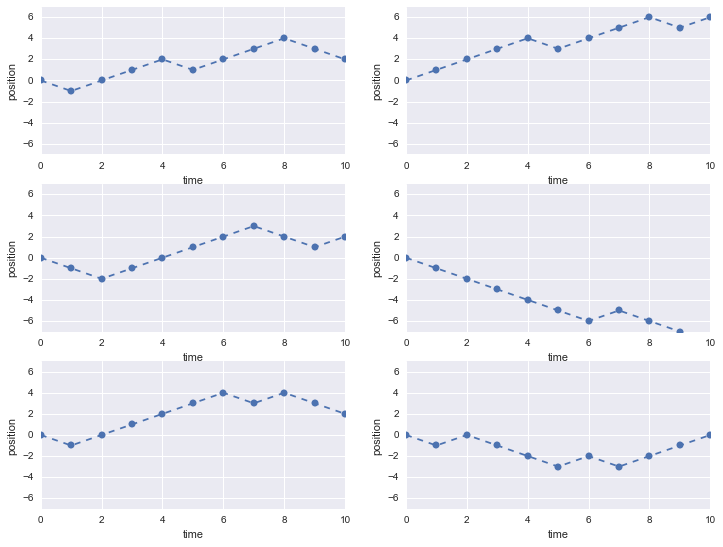

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
%matplotlib inline

class Paths(object):
    
    def __init__(self,T,npaths):
        self.T=T
        self.npaths=npaths
    
    def __setup__(self):
        self.time=np.linspace(0,self.T,self.nsteps)
        self.paths=np.zeros(shape=(self.npaths,self.nsteps))    
    
    def get_paths(self):
        return self.paths
    
    def get_timeline(self):
        return self.time
    
    def __getitem__(self,index):
        return self.paths[index]
    
    def get_step(self,k):
        return self.paths[:,k]
    
class BinaryPaths(Paths):
    
    # The BinaryPath takes the total time and the time after which the increment is to be made
    def __init__(self,T,dt,npaths,p=.5):
        super(BinaryPaths,self).__init__(T,npaths)
        self.p=p
        
        self.dt=dt
        self.nsteps=int(self.T/self.dt)
        Paths.__setup__(self)
        
        self.randoms=2*(np.random.binomial(1,self.p,self.npaths*(self.nsteps-1))-.5)
        self.randoms.shape=[self.npaths,self.nsteps-1]
        
        for i in range(self.nsteps-1):
            self.paths[:,i+1]=self.paths[:,i]+self.randoms[:,i]
            
b_paths=BinaryPaths(11,1,6).get_paths()

number_columns=2
number_rows=3
figsize(12, 9)
for i,j in enumerate([(i/number_columns,i%number_columns) for i in range(number_columns*number_rows)]):
    plt.subplot2grid((number_rows,number_columns),j)
    plt.plot(b_paths[i],"--o")
    plt.xlabel("time")
    plt.ylabel("position")
    plt.ylim(-7,7)


## From Binomial Walk to Weiner Process *but not back*!

The process described above is a Binomial process and happens in discrete times. However for analytical reasons we would like to take a continuum limit of the same. Although having done that, for computational reasons the latter is approximated by a discrete process again. The reason for the analytical expression in continuous time is actually tied to the central limit theorem which for our purposes states that the sum of many independent incrememts by random variables with well defined mean and variance tends to a Gaussian process (the Gaussian is stable under such sums or, as they are known technically, convolutions). Thus if we can pass to a domain where such convergence has happened we do not care about the *microscopic* model anymore.

If the above is not clear already, I hope the plots below will help. Here I generate random walks, same as before, for the time interval $t=[0,10)$ by deviding the interval in 10000 steps. Then we zoom into the central region (any region would do) by factors of 2. You will notice that for the first 5 zoom ins the path looks the same. However, after that the discrete nature of Bernoulli jumps start becoming visible.

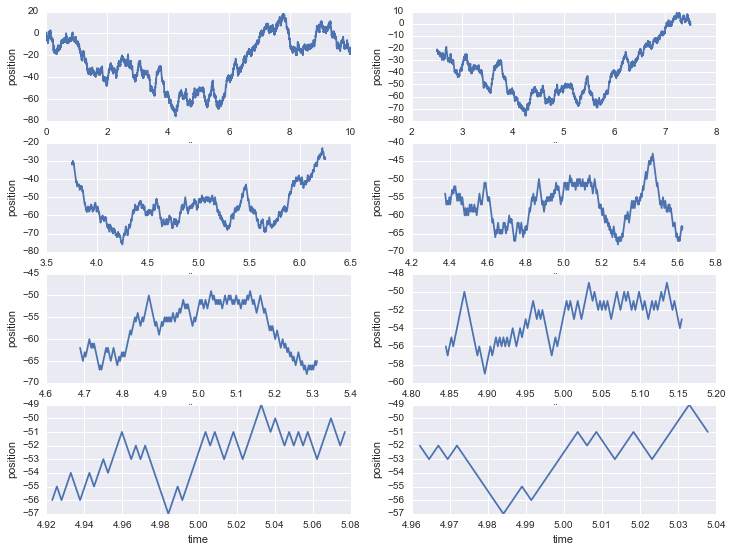

In [2]:
T=10.0
num_steps_bernoulli=2**12  
delta_t_bernoulli=T/num_steps_bernoulli


b=BinaryPaths(10,delta_t_bernoulli,1)
time_line=b.get_timeline()
path=b[0]

number_columns=2
number_rows=4
figsize(12, 9)

# plot the entire path first and then regions zoomed in by factor of 2s
for i,j in enumerate([(i/number_columns,i%number_columns) for i in range(number_columns*number_rows)]):
    plt.subplot2grid((number_rows,number_columns),j)
    time_line_for_plot=time_line[num_steps_bernoulli/2 -num_steps_bernoulli/(2**(i+1)):num_steps_bernoulli/2 +num_steps_bernoulli/(2**(i+1))]
    path_for_plot=path[num_steps_bernoulli/2 -num_steps_bernoulli/(2**(i+1)):num_steps_bernoulli/2 +num_steps_bernoulli/(2**(i+1))]
    
    plt.plot(time_line_for_plot,path_for_plot)
    plt.xlabel("time")
    plt.ylabel("position")

It is intructive to understand what is happening here clearly. The discussion below works for all values of $p$ away from $0$ and $1$ for sufficiently large $n$.

The change in position after $n$ steps is given by
$$
Y_n = 2 Binomial(n,p)-n~.
$$
For large enough $n$ (depending on how important tail events are the cutoffs are different) this can be approximated by
$$ \begin{eqnarray}
Y_n &\sim& 2 \mathcal N(np, \sqrt{n p(1-p)})-n \\
&=& n(2p-1) + 2\sqrt{n p(1-p)} \mathcal N(0,1) \\
&=& n(2p-1) + \sqrt{4 n p(1-p)} \mathcal N(0,1)
\end{eqnarray}
$$

Specializing to $p=.5$, if we progressively look at an interval $\f{n}{2^k}$ we can approximate
$$
Y_n \sim \sqrt{\f{n}{2^k}} \mathcal N(0,1)
$$
and the plot is qualitatively the same as long as $k$ is not large enough to violate the Binomial to Gaussian approximation. In the plots above we have the size of intervals

In [7]:
print [num_steps_bernoulli/2**k for k in range(9)]

[4096, 2048, 1024, 512, 256, 128, 64, 32, 16]


and around n=256 we start seeing differences.


This shows us something interesting. Let us assume that each step takes time $\delta t$ and we are interested in studying processes over time $dt \gg \delta t$ we have 

$$
dY(t) = \mu dt +  \sigma \sqrt{dt} \mathcal N(0,1)
$$
where $\mu = \f{2p-1}{\delta t}$ and $\sigma = \sqrt{\f{4 p (1-p)}{\delta t}}$.

** Take great care to see that there is a square root on $dt$ here. ** This makes the left hand side very different from ordinary calculus differential elements. For instance while the limit
$$
\lim_{dt \to 0} dY(t) 
$$
is well defined and goes to zero, the velocity 
$$
\lim_{dt \to 0} \f{dY(t)}{dt}
$$
is not defined. This signifies that this kind of curve is everywhere non-differentiable.

It would be useful to keep in mind that all this discussion is happening when $dt \to 0$ compared to other large time scales in the problem while maintaining $dt \gg \delta t$ so as to be able to justify the Binomial to Normal approximation above.

The Weiner process is this approximated process taken at **all** scales. In other words one forgets that oen first zoomed out and thus infinite zooming in is possible. This is related to the central limit theorem in that we first take the limit of addining ifinite, independent random variable and get a normal distribution and then subdivide the normal as many times as we like without recovering the original distribution.

Formally the Weiner process is defined as
$$
dW_t = \sqrt{dt} \mathcal N(0,1)
$$
and thus to match our previous example we have $dY = \mu dt+ \sigma dW$.

$dW$ should be interpreted as a random draw from a unit normal multiplied by $\sqrt{dt}$. Thus it is immediately clear that $dW^2$ is drawn from a $\chi^2$ distribution  of one degree of freedom with mean $dt$ and standard deviation $\sqrt{2} dt$. There is hardly a book on stochastic calculus that will not mention $dW^2 = dt$. We can understand it the following way. If we have
$$
\begin{eqnarray}
Q=\sum_{i=1}^N \Delta W_i^2
\end{eqnarray}
$$
with time split as $\Delta t= T/N$ then $Q$ is a $\chi^2_N$ distribution with mean $N \Delta T=T$ and variance $2 N \Delta T^2$ and in the limit $N \to \infty$ the value of $Q  \to T$. It is in this sense, udner the integral/summation, that $dW^2= dt$ even though there is no convergence for any one interval. This is again a result of the central limit theorem. In particular we have the often used results

$$
\mean{dW_t} =0
$$

and

$$
dW_t^2 = dt
$$

However note that if the intervals are independent

$$
\mean{dW_t dW_{t'}} = dt * cov(\mathcal N(0,1),\mathcal N(0,1)) = 0
$$

We can integrate the Weiner process to get
$$
W_t = \int_0^t dW_t = \sqrt{t} \mathcal N(0,1)
$$
giving
$$
\begin{eqnarray}
\mean{W_t} &=& 0 \\
var(W_t) &=& t
\end{eqnarray}
$$

** Covariance of $W_t$ and $W_{t'}$ **

The way the above is written can lead to an erroneous idea (that can seep into code) that $W_t$ and $W_{t'}$ are independet and thus have covariance 0. However, the path from $0$ to $min(t,t')$ is the same so they are not independent. For concreteness take $t' > t$ then what we really have is

$$
\begin{eqnarray}
W_t &=& \sqrt{t} \mathcal N_1 (0,1)
W_{t'-t} &=& \sqrt{t-t'} \mathcal N_2 (0,1)
\end{eqnarray}
$$

where the two subscripts on the normal denote independent draws and

$$
W_{t'} = W_t + W_{t-t'}
$$

giving

$$
\begin{eqnarray}
cov(W_t, W_{t'}) &=& t~cov(\mathcal N_1 (0,1),\mathcal N_1 (0,1)) + \sqrt{t}\sqrt{t'-t} ~cov(\mathcal N_1 (0,1),\mathcal N_2 (0,1)) \\
&=& t
\end{eqnarray}
$$

In general

$$
cov(W_t, W_{t'}) = min(t,t')
$$

We can now simulate paths using the Weiner process and zoom in to see the difference from the Bernoulli process.

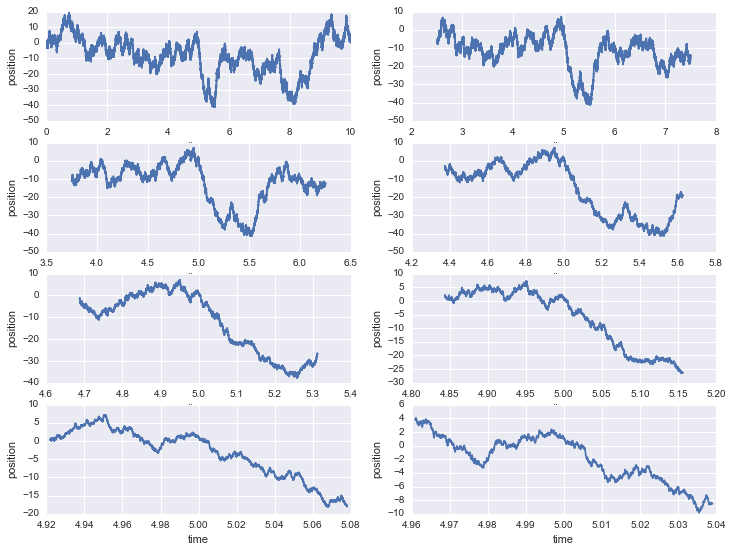

In [3]:
class WeinerPaths(Paths):
    
    
    def __init__(self,T,nsteps,npaths,mu=0,sigma=1):
        super(WeinerPaths,self).__init__(T,npaths)
        
        self.nsteps=nsteps
        self.dt=1.0*self.T/self.nsteps
        Paths.__setup__(self)
        
        self.mu=mu
        self.sigma=sigma
        
        self.dW=np.sqrt(self.dt)
        self.randoms=np.random.normal(0,1,npaths*(nsteps-1))
        self.randoms.shape=[npaths,nsteps-1]
        

        for i in range(nsteps-1):
            self.paths[:,i+1]=self.paths[:,i]+self.mu*self.dt+self.sigma*self.dW*self.randoms[:,i]
        


num_steps_weiner=num_steps_bernoulli*2**6
sigma=1/np.sqrt(delta_t_bernoulli)

# generate one path with time interval 10 devided into 10000 steps
w=WeinerPaths(10,num_steps_weiner,1,sigma=sigma)
time_line=w.get_timeline()
path=w[0]


number_columns=2
number_rows=4
figsize(12, 9)

# plot the entire path first and then regions zoomed in by factor of 2s
for i,j in enumerate([(i/number_columns,i%number_columns) for i in range(number_columns*number_rows)]):
    plt.subplot2grid((number_rows,number_columns),j)
    time_line_for_plot=time_line[num_steps_weiner/2 -num_steps_weiner/(2**(i+1)):num_steps_weiner/2 +num_steps_weiner/(2**(i+1))]
    path_for_plot=path[num_steps_weiner/2 -num_steps_weiner/(2**(i+1)):num_steps_weiner/2 +num_steps_weiner/(2**(i+1))]
    
    plt.plot(time_line_for_plot,path_for_plot)
    plt.xlabel("time")
    plt.ylabel("position")

Before we comment on the differences between the two processes lets make sure they are similar on large time scales.

In [4]:
b=BinaryPaths(10,delta_t_bernoulli,100)
w=WeinerPaths(10,num_steps_weiner,100,sigma=sigma)

print "The variance for the Bernoulli process and the Weiner process are %f and %f" % (b.get_step(num_steps_bernoulli-1).var(),w.get_step(num_steps_weiner-1).var())

The variance for the Bernoulli process and the Weiner process are 3727.806400 and 3927.566219


Visually the two processes look similar when compared over large time scales. However, we see that when zoomed in sufficiently but similarly, the difference between the two process becomes clear. The former changes behavior on scaling but the latter retains it. 